In [105]:
import numpy as np
from pandas.core.frame import DataFrame
import forces
from scipy.integrate import odeint
from scipy.stats import maxwell 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

<h2 style="color:orange">Function to create N randomized particles</h2>

In [106]:
#Initial Velocities 
#drho = v_x*np.sin(theta)*np.cos(phi)+v_y*np.sin(theta)*np.sin(phi)+v_z*np.cos(theta)
#dtheta = v_x*np.cos(theta)*np.cos(phi)+v_y*np.cos(theta)*np.sin(phi)-v_z*np.sin(theta)
#dphi = v_y*np.cos(phi)-v_x*np.sin(phi) 

# make the randomzed optimize later, add other velocities

check = []
par = {
            'l': 40,
            'x_r': 39.107,            
            'Rr': 5.6e-5, 
            'Rp':7.5e-7,
            'R_ratio':0,
            'n_w': 1.326,
            'n_p': 1.572
            }

In [107]:
lambd = 2*np.pi*par['Rr']/par['x_r']       #lamb = 2*pi / k where k = x/Rr
M = (4/3) * np.pi * (par['Rp']**3) *1040   #where density of silica is 1040
tao = 0.00048528                           #value obtained from mathematica
kbt = 1.38064852e-23 * 300                 #value is in eV
alpha = 7.02158e-14
stdevTildaV = (4*kbt*(par['Rr']**3))/(3*(2.92291e-8)*(par['Rp']**3)*lambd)
vavgTilda = np.sqrt(stdevTildaV)
kk=par["x_r"]/par["Rr"]
eta = (0.00700175*M)/(vavgTilda*6*np.pi*(par['Rp'])*tao)#Eta is for Average Rp and Average velocity for all cartesian directions

In [108]:
def rand(N):
    Results = pd.DataFrame(columns=['rand_x','rand_y','rand_z','rho_','theta_','phi_','dRho_','dTheta_','dPhi_','Rp_','gamma_','time_'])
    vx=-0.001421
    vy=0.006615
    vz=0.00112
    rho=39.7
    theta=1.654382
    phi=4.081736
    drho=-0.004582
    dtheta = vx*np.cos(theta)*np.cos(phi)+vy*np.cos(theta)*np.sin(phi)-vz*np.sin(theta)
    dphi = vy*np.cos(phi)-vx*np.sin(phi)
    Rp = np.linspace(7.5*10**(-7) - 3.75*10**(-8), 7.5*10**(-7) + 3.75*10**(-8),N)
    m = (4/3) * np.pi * (Rp**3) *1040
    gamma = (6 * np.pi * eta * tao * Rp)/m
    while Results.count()[0] != N:
        Results = pd.concat([pd.DataFrame([[vx, vy, vz, rho, theta, phi, drho, dtheta, dphi, None, None, None]],columns = Results.columns),Results],ignore_index = True)
    Results['Rp_']=Rp
    Results['gamma_']=gamma
    return Results


In [109]:
def randomized(N):
    Results = pd.DataFrame(columns=['rand_x','rand_y','rand_z','rho_','theta_','phi_','dRho_','dTheta_','dPhi_','Rp_','gamma_','time_'])
    while Results.count()[0] != N:
        Rp = np.random.uniform(7.5*10**(-7) - 3.75*10**(-8), 7.5*10**(-7) + 3.75*10**(-8))
        #random positions
        rho = np.random.uniform(39.107 + ((7.875e-07)*kk) , 39.107 + (3*kk*(7.875e-07))) #3 sizes away
        theta = np.random.uniform(((np.pi/2)-np.sqrt(1/40)),((np.pi/2)+np.sqrt(1/40)))
        phi = np.random.uniform(0,np.pi*2)
        #random velocities
        vx = np.random.normal(0,stdevTildaV)
        vy = np.random.normal(0,stdevTildaV)
        vz = np.random.normal(0,stdevTildaV)
        #rhop is density, 

        m = (4/3) * np.pi * (Rp**3) *1040
        gamma = (6 * np.pi * eta * tao * Rp)/m #gamma tilde, average tao not sepcific to size
        dtheta = vx*np.cos(theta)*np.cos(phi)+vy*np.cos(theta)*np.sin(phi)-vz*np.sin(theta)
        dphi = vy*np.cos(phi)-vx*np.sin(phi)
        dRhodT = vx*np.sin(theta)*np.cos(phi)+vy*np.sin(theta)*np.sin(phi)+vz*np.cos(theta) #vrho 
        Results = pd.concat([pd.DataFrame([[vx, vy, vz, rho, theta, phi, dRhodT, dtheta, dphi, Rp, gamma, None]],columns = Results.columns),Results],ignore_index = True)
    return Results

<h2 style="color:deeppink">ODE Solver Function</h2>

In [110]:
TC = []
def f(u, t, par, gamma,Rp):
    rho, drho, theta, dtheta, phi, dphi = u     
    dudt = [
                drho, forces.rho(rho, theta, par) - gamma * drho + rho * (dtheta * np.cos(phi)) ** 2 + rho * dphi ** 2,
                dtheta, (forces.theta(rho, theta, par) - gamma * rho * dtheta * np.cos(phi) - 2 * drho * dtheta * np.cos(phi) + 2 * rho * dtheta * dphi * np.sin(phi)) / (rho * np.cos(phi)),
                dphi, (forces.phi(rho, theta, par) - gamma * rho * dphi - 2 * drho * dphi - rho * dphi ** 2 * np.sin(phi) * np.cos(phi)) / rho
            ]
    return dudt

<span style="color:red">Automates solution for multiple particles</span>

In [127]:

def solve(Results):
    k = pd.DataFrame(columns=["rho","theta", "time","Rp_"])
    g = pd.DataFrame(columns=["rho", "theta","time","Rp_"])

    j = 0
    time = np.linspace(0,40,300)
    while j != len(Results.index):
        gamma_ = Results['gamma_'][j]
        Rp_ = Results['Rp_'][j]
        par['R_ratio'] = Rp_/(5.6*10**(-5))  

        u0 = [Results['rho_'][j],Results['dRho_'][j], Results['theta_'][j], Results['dTheta_'][j], Results['phi_'][j], Results['dPhi_'][j]]
        sol = odeint(f, u0, time, args = (par, gamma_,Rp_))
        
        k["rho"] = sol[:,0]
        k["theta"] = sol[:,2]
        k["time"] = time
        k["Rp_"] = [Rp_]*300
        
        k = k[(k.rho <= 39.107+(kk*Rp_)) & (k.rho >= 39.170)].sort_values(by='rho',ascending=False).head(1) #check here to see how is k defined only place to go wrong is here
        g = pd.concat([k, g],ignore_index = True)
        k = pd.DataFrame(columns=["rho", "theta", "time", "Rp_"])
        
        j+=1
    return [g]


In [128]:
#10 runs of 100 solutions pick top 10 fastest in each case and make histogram 
Res = pd.DataFrame(columns=['rho','theta','time','Rp_'])
Res2 = pd.DataFrame(columns=['rho','theta', 'time','Rp_'])
Res3 = pd.DataFrame(columns=['rand_x','rand_y','rand_z','rho_','theta_','phi_','dRho_','dTheta_','dPhi_','Rp_','gamma_','time_'])
for i in range(100000):
    if i%10000 == 0:
        print(i)
    F = randomized(100)
    g = solve(F)
    z = g[0].sort_values('time') #everything that reached 
    top = z.head(1) #the fisrt one that reached 
    Res = pd.concat([top, Res],ignore_index = True)
    Res2 = pd.concat([z, Res2],ignore_index = True)
    Res3 = pd.concat([F, Res3],ignore_index = True)



0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


10000
20000
30000
40000
50000
60000
70000
80000
90000


1


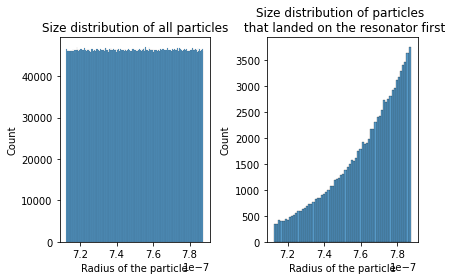

In [130]:
plt.rcParams["figure.autolayout"] = True
#hi
print(1)
fig, axes = plt.subplots(1, 2)
axes[0].set_xlabel("Radius of the particle")
axes[1].set_xlabel("Radius of the particle")
axes[0].set_title("Size distribution of all particles")
axes[1].set_title("Size distribution of particles \n that landed on the resonator first")
sns.histplot(data = Res, x = 'Rp_', ax=axes[1])
sns.histplot(data = Res3, x = 'Rp_', ax=axes[0])
plt.show()

In [129]:
Res.to_csv('TheOnesThatReachedFirst3_xy.csv')
Res2.to_csv('TheOnesThatReachedFromTheTotal3_xy.csv')
Res3.to_csv('TotalRandomGeneratedData3_xy.csv')

Text(0, 0.5, 'Time of arrival')

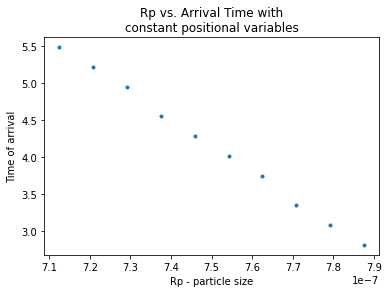

In [55]:
F = rand(10)
z = solve(F)[0]
plt.plot(z["Rp_"],z["time"],".")
plt.title("Rp vs. Arrival Time with\nconstant positional variables")
plt.xlabel("Rp - particle size")
plt.ylabel("Time of arrival")